#### 데이터 불러오기

In [12]:
import pandas as pd
import numpy as np
import pickle
### VIF
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
### 모델링
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 모델들
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
# Tree 시각화
from sklearn.tree import export_graphviz
from subprocess import check_call
from graphviz import Source
from IPython.display import Image
# 업샘플링
from sklearn.utils import resample
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
!apt-get -qq install fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


#### 데이터 불러오기~

In [13]:
pothole = pd.read_pickle('/content/drive/MyDrive/DATA_완성/pothole_예측용.pickle')
pothole.head(2)

,자치구,행정동,경도,위도,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,...,등록번호,발생일,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도,자치구_enc
0,강남구,개포동,127.075036,37.486016,1.0,-0.355737,-0.057007,-0.295055,-0.360729,0.079294,...,NaN,NaN,0.928563,-0.599417,-0.038033,-1.144723,0.668894,4.0,2.0,0
1,강남구,개포동,127.074160,37.485413,1.0,-0.355737,-0.057007,-0.295055,-0.360729,0.079294,...,NaN,NaN,0.928563,-0.599417,-0.038033,-1.144723,0.668894,4.0,4.0,0


In [14]:
pothole.rename(columns = {'포트홀 갯수' : '포트홀 개수'}, inplace = True)
pothole.columns

Index(['자치구', '행정동', '경도', '위도', '차선수', '승용차', '버스', '트럭', '총교통량', '중대형차량 교통량',
       '포트홀 개수', '평균_건물연령', '등록번호', '발생일', '인구 수', '누적 강수량', '평균 습도', '1년 기온차',
       '평균 일교차', '배수등급', '경사도', '자치구_enc'],
      dtype='object')

#### VIF 체크

In [18]:
### x, y 할당
x = pothole.drop(['자치구', '행정동', '경도', '위도', '등록번호', '발생일', '포트홀 개수', '자치구_enc'], axis=1)
y = pothole['포트홀 개수']

In [21]:
# 출력용 데이터프레임
vif = pd.DataFrame()
# 값, 각 feature 이름
vif['Feature'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

vif = vif.sort_values(by = 'VIF', ascending = False).reset_index().drop('index', axis = 1)
vif

,Feature,VIF
0,승용차,3716.630314
1,총교통량,3659.999013
2,트럭,79.512322
3,중대형차량 교통량,36.266177
4,버스,10.731937
5,배수등급,5.668685
6,차선수,4.545533
7,경사도,2.039120
8,1년 기온차,1.592543
9,평균 일교차,1.370654


In [22]:
# 총교통량, 중대형차량 교통량 우선 제거
x = x.drop(['총교통량', '중대형차량 교통량'], axis = 1)

# 출력용 데이터프레임
vif = pd.DataFrame()
# 값, 각 feature 이름
vif['Feature'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

vif = vif.sort_values(by = 'VIF', ascending = False).reset_index().drop('index', axis = 1)
vif

,Feature,VIF
0,트럭,5.727814
1,승용차,5.393911
2,배수등급,5.357568
3,차선수,4.230469
4,경사도,2.027544
5,버스,1.950866
6,1년 기온차,1.584108
7,평균 일교차,1.367659
8,누적 강수량,1.303570
9,인구 수,1.279090


괜찮다! 이대로 진행 ~~

### x, y 할당

In [24]:
### x, y 할당
x = pothole.drop(['자치구', '행정동', '경도', '위도', '등록번호', '발생일', '포트홀 개수', '자치구_enc', '총교통량', '중대형차량 교통량'], axis=1)
y = pothole['포트홀 개수']
x.head(2)

,차선수,승용차,버스,트럭,평균_건물연령,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도
0,1.0,-0.355737,-0.057007,-0.295055,-0.363365,0.928563,-0.599417,-0.038033,-1.144723,0.668894,4.0,2.0
1,1.0,-0.355737,-0.057007,-0.295055,-0.363365,0.928563,-0.599417,-0.038033,-1.144723,0.668894,4.0,4.0


In [ ]:
### 날씨 제외하고
x2 = x.drop(['누적 강수량', '평균 습도', '1년 기온차', '평균 일교차'], axis = 1)
x2.head(2)

,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,평균_건물연령,인구 수,배수등급,경사도
0,3.0,0.158441,1.284569,0.160536,0.206347,0.686938,-0.581126,-2.223687,2.0,0.0
1,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,-0.581126,-2.223687,2.0,0.0


In [25]:
### train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1391)

#### Metric

실제보다 적게 예측하는 게 더 위험하니까...

적게 예측한 경우 더 크게 반영하도록 메트릭 설정

In [46]:
def less_no(y_true, y_pred):
    error = y_true - y_pred
    loss = np.where(error > 0, 2*np.abs(error), np.abs(error))
    return np.mean(loss)

lessno 값이 작을 수록 좋다

#### KNN

In [34]:
### Hyperparameter
# model
knn = KNeighborsRegressor()
param_grid = {'n_neighbors' : range(80,110)}
# gridsearch
knn_cv = GridSearchCV(knn, param_grid, cv = 5, scoring = 'r2')
knn_cv.fit(x_train, y_train)
# optimal parameter
print('GridSearch 최고 평균 성능 : {:.4f}'. format(knn_cv.best_score_)) # r2의 평균
print('GridSearch 최적 파라미터 : ', knn_cv.best_params_)

GridSearch 최고 평균 성능 : 0.1334
GridSearch 최적 파라미터 :  {'n_neighbors': 81}


아니 neighbor 수를 점점 늘릴 수록 성능이 올라가,,,

In [47]:
####### KNN ##########################
### fitting
knn_model = KNeighborsRegressor(n_neighbors = 81)
knn_model.fit(x_train, y_train)
### prediction
knn_pred = knn_model.predict(x_test)
### accuracy
knn_mse = mean_squared_error(y_test, knn_pred)
knn_r2 = r2_score(y_test, knn_pred)
knn_less_no = less_no(y_test, knn_pred)
print("KNN - MSE : {:.4f}".format(knn_mse))
print("KNN - R²: {:.4f}".format(knn_r2))
print("KNN - lessno : {:.4f}".format(knn_less_no))

KNN - MSE : 9.5764
KNN - R²: 0.1755
KNN - lessno : 1.7643


#### Tree

In [40]:
### Hyperparameter - 일단은 train 기준으로만
# model
tree = DecisionTreeRegressor()
param_grid = {'max_depth' : range(1,15)}
tree_cv = GridSearchCV(tree, param_grid = param_grid, cv = 5)
tree_cv.fit(x_train, y_train)

print('GridSearch 최고 평균 성능 : {:.4f}'. format(tree_cv.best_score_))
print('GridSearch 최적 파라미터 : ', tree_cv.best_params_)

GridSearch 최고 평균 성능 : 0.1387
GridSearch 최적 파라미터 :  {'max_depth': 3}


In [48]:
####### Tree ##########################
### fitting
tree_model = DecisionTreeRegressor(max_depth = 3)
tree_model.fit(x_train, y_train)
### prediction
tree_pred = tree_model.predict(x_test)
### accuracy
tree_mse = mean_squared_error(y_test, tree_pred)
tree_r2 = r2_score(y_test, tree_pred)
tree_less_no = less_no(y_test, tree_pred)
print("Tree - MSE : {:.4f}". format(tree_mse))
print("Tree - R2 : {:.4f}".format(tree_r2))
print("Tree - lessno : {:.4f}".format(tree_less_no))

Tree - MSE : 9.3514
Tree - R2 : 0.1949
Tree - lessno : 1.7496


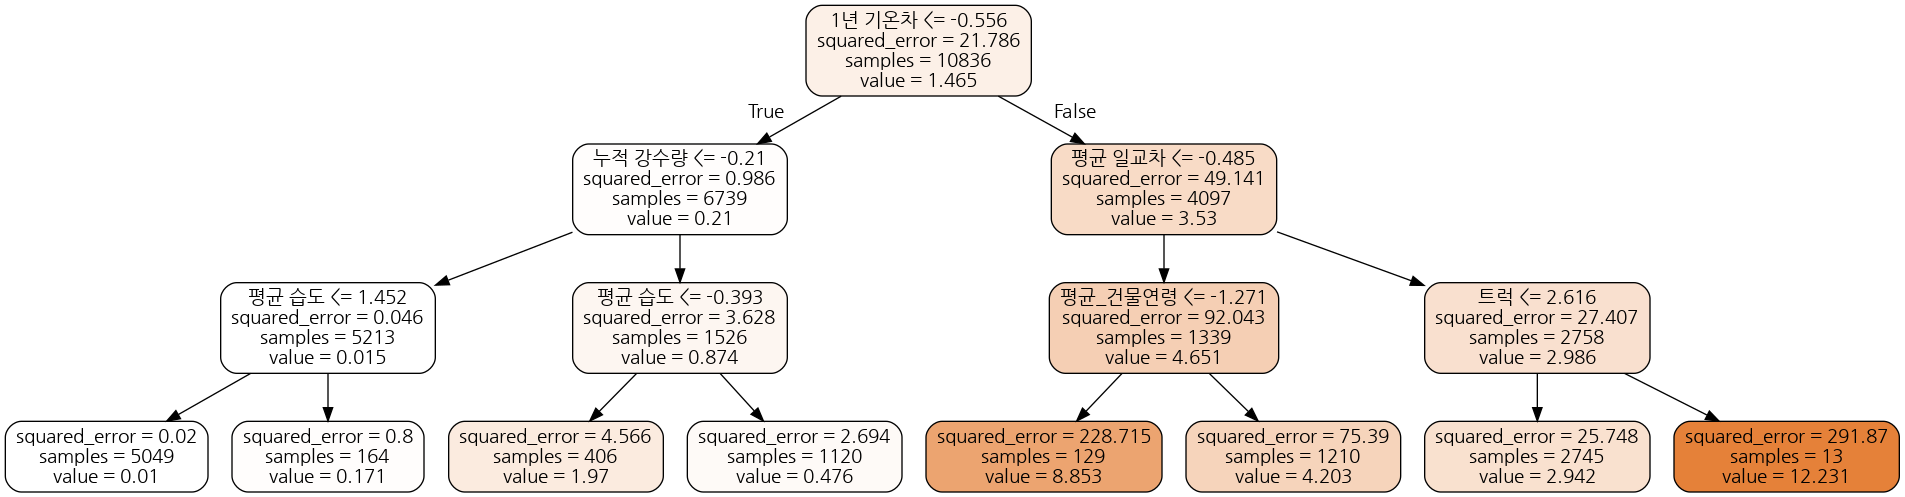

In [42]:
tree_model_dot = export_graphviz(tree_model,
                                 out_file = None,
                                 class_names = [str(cls) for cls in y_train.unique()],
                                feature_names = x_train.columns,
                                 rounded = True, filled = True, fontname="NanumGothic")
graph = Source(tree_model_dot)
graph.render("tree_model", format = "png")
Image(filename = "tree_model.png")

### 결과

In [49]:
print(
    "KNN MSE: {:.4f}".format(knn_mse),
    "Tree MSE: {:.4f}".format(tree_mse),
    sep = '\n'
)

print("-------------------------------")
print(
    "KNN R2: {:.4f}".format(knn_r2),
    "Tree R2: {:.4f}".format(tree_r2),
    sep = '\n'
)
print("-------------------------------")

print(
    "KNN lessno: {:.4f}".format(knn_less_no),
    "Tree lessno: {:.4f}".format(tree_less_no),
    sep = '\n'
)

KNN MSE: 9.5764
Tree MSE: 9.3514
-------------------------------
KNN R2: 0.1755
Tree R2: 0.1949
-------------------------------
KNN lessno: 1.7643
Tree lessno: 1.7496
